In [59]:
#imports
import numpy as np; import pandas as pd; import random; from scipy.spatial.distance import cdist; import matplotlib.pyplot as plt;
plt.rcParams['figure.figsize'] = [10, 5]


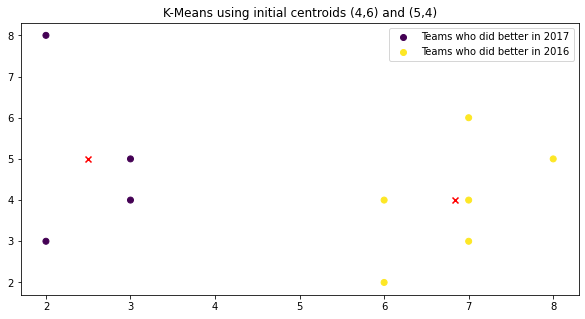

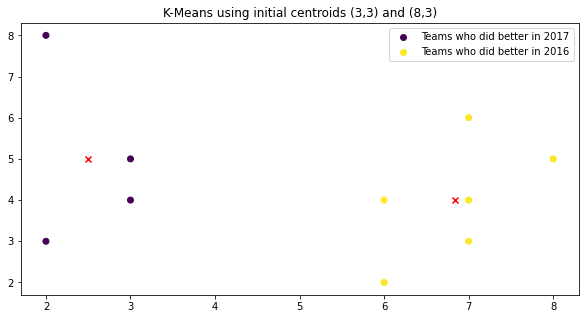

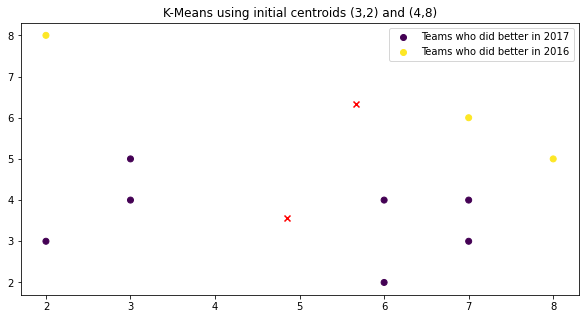

In [60]:
#task 1
from sklearn.cluster import KMeans
data = pd.read_csv('team_game_data.csv')
data = data.drop('team', 1)

params = [
    {
        'title': 'K-Means using initial centroids (4,6) and (5,4)',
        'init': [[4,6],[5,4]]
    },
    {
        'title': 'K-Means using initial centroids (3,3) and (8,3)',
        'init': [[3,3],[8,3]]
    },
    {
        'title': 'K-Means using initial centroids (3,2) and (4,8)',
        'init': [[3,2],[4,8]]
    }
]

for i in range(3):
    kmeans  = KMeans(n_clusters=2, init=np.array(params[i]['init'])).fit(data)
    centroids = kmeans.cluster_centers_
    scatter = plt.scatter(data['wins_2016'], data['wins_2017'], c= kmeans.labels_.astype(float), label='a')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')
    handles, _ = scatter.legend_elements()
    plt.legend(handles, ['Teams who did better in 2017','Teams who did better in 2016'], loc="upper right")
    plt.title(params[i]['title'])
    plt.show()


In [61]:

data = pd.read_csv('../Iris/iris.csv')
labels = data['label']
# data = data[['sepal_length','sepal_width','petal_length','petal_width']]

In [62]:
#get centroids 
def get_initial_centroids(X, k):
    n_samples = X.shape[0]
    ids = random.sample(range(0, n_samples), k)

    centroids = [tuple(X[id]) for id in ids]
    unique_centroids = list(set(centroids))

    n_unique_centroids = len(unique_centroids)

    while n_unique_centroids < k:
        new_ids = random.sample(range(0, n_samples), k - n_unique_centroids)
        new_centroids = [tuple(X[id]) for id in new_ids]
        unique_centroids = list(set(unique_centroids + new_centroids))

        n_unique_centroids = len(unique_centroids)

    return np.array(unique_centroids)

#euclidean,cosine,jaccard
def get_distance(A_matrix, B_matrix, function):
    if function == 'jaccard':
        result = []
        for p in A_matrix:
            jaccards = []
            for c in B_matrix:
                dist = 1 - ((min(p[1], c[1]) + min(p[0], c[0]))/(max(p[1], c[1]) + max(p[0], c[0])))
                jaccards.append(dist)
            result.append(jaccards)
        return np.array(result)
    else:
        return cdist(A_matrix, B_matrix, function)

def get_clusters(X, centroids, distance_function):
    k = centroids.shape[0]
    clusters = {}
    distance_matrix = get_distance(X, centroids, distance_function)
    closest_cluster_ids = np.argmin(distance_matrix, axis=1)
    for i in range(k):
        clusters[i] = []
    for i, cluster_id in enumerate(closest_cluster_ids):
        clusters[cluster_id].append(X[i])
    return clusters

def has_centroids_covered(previous_centroids, new_centroids, distance_function, movement_threshold_delta):
    distance = get_distance(previous_centroids, new_centroids, distance_function)
    centroids_covered = np.max(distance.diagonal()) <= movement_threshold_delta

    return centroids_covered

def K_Means(X, k, distance_function, movement_threshold_delta=0):
    new_centroids = get_initial_centroids(X=X, k=k)

    centroids_covered = False

    while not centroids_covered:
        previous_centroids = new_centroids
        clusters = get_clusters(X, previous_centroids, distance_function)

        new_centroids = np.array([np.mean(clusters[key], axis=0, dtype=X.dtype) for key in sorted(clusters.keys())])

        centroids_covered = has_centroids_covered(previous_centroids, new_centroids, distance_function, movement_threshold_delta)

    return new_centroids

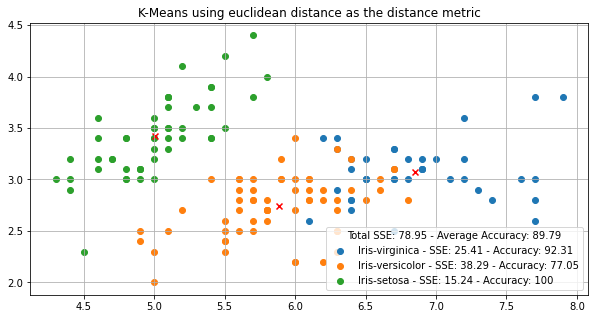

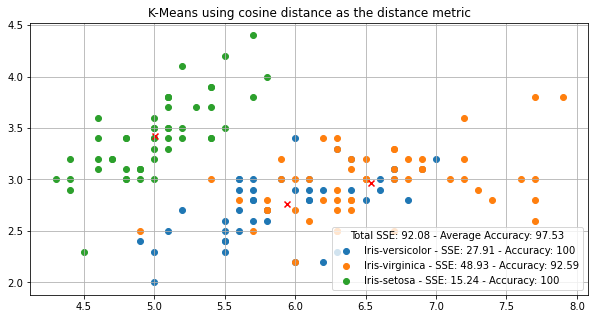

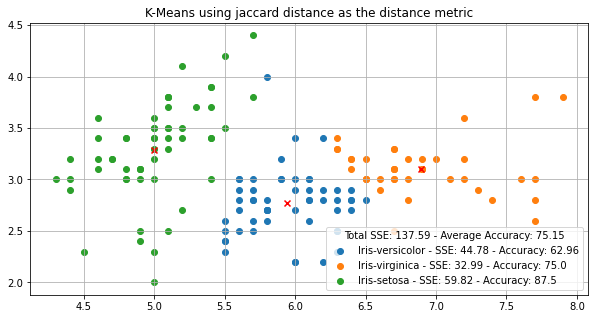

In [141]:
from sklearn.decomposition import PCA;  from collections import Counter;import statistics;
plt.rcParams['figure.figsize'] = [10, 5]
k = 3

#sklearn
# pca_ = PCA(n_components=2)
# pca_transformation = pca_.fit_transform(data)
params = [
    {
        'method': 'euclidean',
        'delta': 0
    },
    {
        'method': 'cosine',
        'delta': 0.0001
    },
    {
        'method': 'jaccard',
        'delta': 0.0001
    }
]


for n in params:
    no_label = data[['sepal_length','sepal_width','petal_length','petal_width']]
    centroids = K_Means(no_label.to_numpy(), k, n['method'], movement_threshold_delta=n['delta'])
    clusters = get_clusters(no_label.to_numpy(), centroids, n['method'])
    scatters = []
    errors = []
    for centroid, points in clusters.items():
        points = np.array(points)
        centroid = np.mean(points, axis=0)
        dists = cdist(points, np.array([centroid]), 'euclidean')
        sum = 0
        labels = []
        for p in points:
            realLabel = data.loc[(data['sepal_length'] == p[0]) & (data['sepal_width'] == p[1]) & (data['petal_length'] == p[2]) & (data['petal_width'] == p[3])].iloc[0]['label']
            labels.append(realLabel)
        labels = np.array(labels)
        labels, counts = np.unique(labels, return_counts=True)
        realLabel = labels[counts == counts.max()][0]
        accuracy = 0
        if len(labels) == 1:
            accuracy = 100
        else:
            countsSum = np.sum(counts)
            c = counts[labels == realLabel][0]
            accuracy = (c/countsSum)*100
        accuracy = round(accuracy, 2)
        for d in dists:
            sum += d[0]**2
        scatter = plt.scatter(points[:, 0], points[:, 1], marker='o')
        scatters.append(scatter)
        errors.append((sum, realLabel, accuracy))
        plt.grid()
        plt.scatter(centroid[0], centroid[1], marker='x', color="red")
    plt.title(f'K-Means using {n["method"]} distance as the distance metric')
    legends = map((lambda x: str(x[1]) + ' - SSE: ' + str(round(x[0], 2)) + ' - Accuracy: ' + str(x[2])), errors)
    sse = 0
    for e in errors:
        sse += e[0]
    plt.legend(scatters, legends, loc="lower right", title='Total SSE: ' + str(round(sse, 2)) + ' - Average Accuracy: ' + str(round(statistics.mean(map(lambda x: x[2], errors)), 2)))
    plt.show()